In [1]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
COLOR_DICT = {"noaa":"blue","cys":"red","met":"green","cob":"orangered","cobmet":"gold"}
LABEL_DICT = {"noaa":"No AA's", "cys":"+ Cysteine", "met":"+ Methionine","cob":"+ Cobalamin","cobmet":"+ Cobalamin/Methionine"}

In [4]:
tecan_full_df = pd.read_csv("../data/tecan/19022025/19_02_2025_tecan_data.csv",sep=";")
tecan_full_df = tecan_full_df.dropna(axis=1)
tecan_full_df.head()

,Zyklus Nr.,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
0,Zeit [s],0,"600,1","1200,2","1800,3","2400,3","3000,4","3600,5","4200,6","4800,7",...,"423056,7","423656,8","424256,9",424857,425457,"426057,1","426657,2","427257,3","427857,3","428457,4"
1,Temp. [�C],"18,5","17,9","18,3","18,4","18,4","18,2","17,9","18,9","18,6",...,"18,4","17,9","18,8","18,3","17,9","18,8","18,2","17,8","18,7","18,2"
2,A1,"0,083700001","0,084399998","0,084399998","0,084600002","0,084700003","0,084799998","0,084899999","0,085299999","0,085100003",...,"0,086999997","0,087499999","0,087099999","0,087499999","0,087499999","0,086800002","0,087499999","0,087399997","0,086800002","0,088"
3,A3,"0,107199997","0,1105","0,082500003","0,082599998","0,0823","0,082699999","0,082500003","0,082900003","0,0823",...,"0,080300003","0,081200004","0,080899999","0,080399998","0,080899999","0,080700003","0,080399998","0,0814","0,080700003","0,0814"
4,A5,"0,094999999","0,0823","0,080600001","0,080499999","0,079999998","0,080499999","0,079800002","0,080399998","0,079400003",...,"0,95569998","0,951499999","0,952300012","0,955900013","0,958500028","0,958800018","0,953400016","0,954699993","0,958100021","0,960300028"


In [5]:
tecan_df = tecan_full_df.iloc[2:,:]
tecan_df = tecan_df.rename(columns={"Zyklus Nr.":"well"})
tecan_df.head()

,well,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
2,A1,"0,083700001","0,084399998","0,084399998","0,084600002","0,084700003","0,084799998","0,084899999","0,085299999","0,085100003",...,"0,086999997","0,087499999","0,087099999","0,087499999","0,087499999","0,086800002","0,087499999","0,087399997","0,086800002","0,088"
3,A3,"0,107199997","0,1105","0,082500003","0,082599998","0,0823","0,082699999","0,082500003","0,082900003","0,0823",...,"0,080300003","0,081200004","0,080899999","0,080399998","0,080899999","0,080700003","0,080399998","0,0814","0,080700003","0,0814"
4,A5,"0,094999999","0,0823","0,080600001","0,080499999","0,079999998","0,080499999","0,079800002","0,080399998","0,079400003",...,"0,95569998","0,951499999","0,952300012","0,955900013","0,958500028","0,958800018","0,953400016","0,954699993","0,958100021","0,960300028"
5,A7,"0,080899999","0,074000001","0,074000001","0,074199997","0,074100003","0,074600004","0,074900001","0,074699998","0,075000003",...,"0,079700001","0,079599999","0,079800002","0,079700001","0,079700001","0,079999998","0,079700001","0,079599999","0,079999998","0,079800002"
6,A8,"0,076800004","0,077500001","0,0779","0,0779","0,078299999","0,078299999","0,078500003","0,078699999","0,078699999",...,"0,086300001","0,086400002","0,086099997","0,0858","0,086300001","0,086099997","0,086300001","0,086199999","0,0867","0,086099997"


In [6]:
def change_datatype_to_float(x)->float:
    try:
        if type(x) == str:
            x = x.replace(",",".")
        return float(x)
    except Exception as e:
        raise Exception("[-] ERROR with exception: {}".format(e))    

In [7]:
tecan_df.iloc[:,1:] = tecan_df.iloc[:,1:].applymap(change_datatype_to_float)
tecan_df.head()

,well,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
2,A1,0.0837,0.0844,0.0844,0.0846,0.0847,0.0848,0.0849,0.0853,0.0851,...,0.087,0.0875,0.0871,0.0875,0.0875,0.0868,0.0875,0.0874,0.0868,0.088
3,A3,0.1072,0.1105,0.0825,0.0826,0.0823,0.0827,0.0825,0.0829,0.0823,...,0.0803,0.0812,0.0809,0.0804,0.0809,0.0807,0.0804,0.0814,0.0807,0.0814
4,A5,0.095,0.0823,0.0806,0.0805,0.08,0.0805,0.0798,0.0804,0.0794,...,0.9557,0.9515,0.9523,0.9559,0.9585,0.9588,0.9534,0.9547,0.9581,0.9603
5,A7,0.0809,0.074,0.074,0.0742,0.0741,0.0746,0.0749,0.0747,0.075,...,0.0797,0.0796,0.0798,0.0797,0.0797,0.08,0.0797,0.0796,0.08,0.0798
6,A8,0.0768,0.0775,0.0779,0.0779,0.0783,0.0783,0.0785,0.0787,0.0787,...,0.0863,0.0864,0.0861,0.0858,0.0863,0.0861,0.0863,0.0862,0.0867,0.0861


In [60]:
tecan_layout = pd.read_csv("../data/tecan/19022025/19_02_2025_tecan_layout.csv",sep=";")
tecan_layout = tecan_layout.rename(columns={"Column1":"well"})
tecan_layout.head()

,well,1,2,3,4,5,6,7,8
0,A,noaa,NaN,cys,NaN,met,NaN,Bnoaa,Bmet
1,B,noaa,NaN,cys,NaN,met,NaN,Bnoaa,Bmet
2,C,noaa,NaN,cys,NaN,met,NaN,Bnoaa,Bmet
3,D,noaa,NaN,cys,NaN,met,NaN,Bcys,NaN
4,E,noaa,NaN,cys,NaN,met,NaN,Bcys,NaN


In [4]:
def collect_samples_and_blanks(tecan_layout_df:pd.DataFrame)->tuple:
    try:
        sample_to_blank = {}
        sample_to_well = {}
        blank_to_well = {}
        
        for col in tecan_layout_df:
            if col != "well":
                for index,item in enumerate(tecan_layout_df[col]):
                    if type(item) == str:
                        if "B" in item:
                            if item not in list(blank_to_well.keys()):
                                blank_to_well[item] = [tecan_layout_df["well"][index] + col]
                            else:
                                blank_to_well[item].append(tecan_layout_df["well"][index] + col)
                        else:
                            if item not in list(sample_to_well.keys()):
                                sample_to_well[item] = [tecan_layout_df["well"][index] + col]
                            else:
                                sample_to_well[item].append(tecan_layout_df["well"][index] + col)
                                
        for blank in blank_to_well.keys():
            sample_to_blank[blank.replace("B","")] = blank

        return sample_to_well, blank_to_well, sample_to_blank
    except Exception as e:
        raise Exception("[-] ERROR with exception: {}".format(e))

In [62]:
sample_dict, blank_dict, s_to_b = collect_samples_and_blanks(tecan_layout)

In [5]:
def get_data(sample_to_well:dict,blank_to_well:dict, sample_to_blank:dict, tecan_df:pd.DataFrame)->dict:
    try:
        sample_to_data = {}
        for sample in sample_to_well.keys():
        
            sample_df = tecan_df[tecan_df["well"].isin(sample_to_well[sample])].iloc[:,1:]
            blank_df = tecan_df[tecan_df["well"].isin(blank_to_well[sample_to_blank[sample]])].iloc[:,1:].mean(axis=0)
            blank_corrected_sample_df = sample_df - blank_df

            def negative_to_zero(x):
                if x <= 0:
                    return 0.0000000000000000001
                else:
                    return x
            blank_corrected_sample_df = blank_corrected_sample_df.applymap(negative_to_zero)

            blank_corrected_sample_df = blank_corrected_sample_df.T
            
            for col in blank_corrected_sample_df.columns:
                blank_corrected_sample_df[col] = savgol_filter(blank_corrected_sample_df[col],50,1)

            blank_corrected_sample_df = blank_corrected_sample_df.T
            mean_vals = blank_corrected_sample_df.mean(axis=0)
            std_err = blank_corrected_sample_df.std(axis=0)
            
            sample_to_data[sample] = [mean_vals, std_err, blank_corrected_sample_df, sample_df, blank_df]

        return sample_to_data
    except Exception as e:
        raise Exception("[-] ERROR with exception: {}".format(e))

In [64]:
s_to_d = get_data(sample_dict, blank_dict, s_to_b, tecan_df)

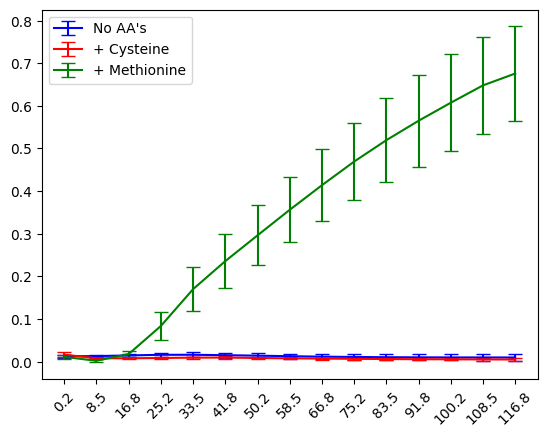

In [65]:
for sample in s_to_d.keys():
    mean_vals = s_to_d[sample][0]
    std_err = s_to_d[sample][1]
    plt.errorbar(x=range(len(mean_vals[::50])), y=mean_vals[::50], yerr=std_err[::50], capsize=5, color=COLOR_DICT[sample], label=LABEL_DICT[sample])
plt.xticks(range(len(mean_vals[::50])), np.round((np.array(mean_vals[::50].index).astype(float)*10)/60,1), rotation=45)
plt.legend()

# Cobalamin DataFrame

In [6]:
tecan_full_df = pd.read_csv("../data/tecan/11032025/11_03_2025_tecan_data.csv",sep=";")
tecan_full_df = tecan_full_df.dropna(axis=1)
tecan_df = tecan_full_df.iloc[2:,:]
tecan_df = tecan_df.rename(columns={"Zyklus Nr.":"well"})
tecan_df.head()

,well,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,558,559,560,561,562
2,A1,"0,084600002","0,084700003","0,084899999","0,085199997","0,085100003","0,0854","0,086000003","0,086199999","0,086000003",...,"0,435000002","0,434100002","0,438199997","0,437599987","0,433299989","0,430799991","0,431100011","0,431899995","0,432099998","0,433600008"
3,A2,"0,073399998","0,076300003","0,073799998","0,074000001","0,073899999","0,073799998","0,073799998","0,073899999","0,073799998",...,"0,075199999","0,075300001","0,075000003","0,075099997","0,075099997","0,075000003","0,075000003","0,075300001","0,075000003","0,075000003"
4,A3,"0,095299996","0,099399999","0,0876","0,087499999","0,087300003","0,087099999","0,087300003","0,0867","0,086599998",...,"0,601899981","0,601499975","0,610099971","0,609000027","0,602999985","0,606000006","0,606299996","0,60799998","0,610300004","0,614799976"
5,A4,"0,075900003","0,082500003","0,075499997","0,075499997","0,075400002","0,075400002","0,075499997","0,075499997","0,075400002",...,"0,077200003","0,077399999","0,077","0,077100001","0,077100001","0,077100001","0,077","0,077399999","0,077","0,077100001"
6,A5,"0,097599998","0,107100002","0,097199999","0,097499996","0,096900001","0,096699998","0,096600004","0,096500002","0,096299998",...,"1,154299974","1,154800057","1,156299949","1,156000018","1,155300021","1,156200051","1,157199979","1,158499956","1,158499956","1,159700036"


In [7]:
tecan_df.iloc[:,1:] = tecan_df.iloc[:,1:].applymap(change_datatype_to_float)
tecan_df.head()

,well,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,558,559,560,561,562
2,A1,0.0846,0.0847,0.0849,0.0852,0.0851,0.0854,0.086,0.0862,0.086,...,0.435,0.4341,0.4382,0.4376,0.4333,0.4308,0.4311,0.4319,0.4321,0.4336
3,A2,0.0734,0.0763,0.0738,0.074,0.0739,0.0738,0.0738,0.0739,0.0738,...,0.0752,0.0753,0.075,0.0751,0.0751,0.075,0.075,0.0753,0.075,0.075
4,A3,0.0953,0.0994,0.0876,0.0875,0.0873,0.0871,0.0873,0.0867,0.0866,...,0.6019,0.6015,0.6101,0.609,0.603,0.606,0.6063,0.608,0.6103,0.6148
5,A4,0.0759,0.0825,0.0755,0.0755,0.0754,0.0754,0.0755,0.0755,0.0754,...,0.0772,0.0774,0.077,0.0771,0.0771,0.0771,0.077,0.0774,0.077,0.0771
6,A5,0.0976,0.1071,0.0972,0.0975,0.0969,0.0967,0.0966,0.0965,0.0963,...,1.1543,1.1548,1.1563,1.156,1.1553,1.1562,1.1572,1.1585,1.1585,1.1597


In [8]:
tecan_layout = pd.read_csv("../data/tecan/11032025/11_03_2025_tecan_layout.csv",sep=";")
tecan_layout = tecan_layout.rename(columns={"Column1":"well"})
tecan_layout.head()

,well,1,2,3,4,5,6,7,8
0,A,NaN,Bnoaa,met,Bmet,cob,Bcob,cobmet,Bcobmet
1,B,noaa,Bnoaa,met,Bmet,cob,Bcob,cobmet,Bcobmet
2,C,noaa,Bnoaa,met,Bmet,cob,Bcob,cobmet,Bcobmet
3,D,noaa,NaN,met,NaN,cob,NaN,cobmet,NaN
4,E,noaa,NaN,met,NaN,cob,NaN,cobmet,NaN


In [10]:
sample_dict, blank_dict, s_to_b = collect_samples_and_blanks(tecan_layout)

In [11]:
s_to_d = get_data(sample_dict, blank_dict, s_to_b, tecan_df)

In [9]:
COLOR_DICT = {"noaa":"#0072B2","met":"#E69F00","cob":"#009E73","cobmet":"#CC79A7"}
LABEL_DICT = {"noaa":"No AA's", "met":"Methionine","cob":"Cobalamin","cobmet":"Cobalamin\n& Methionine"}

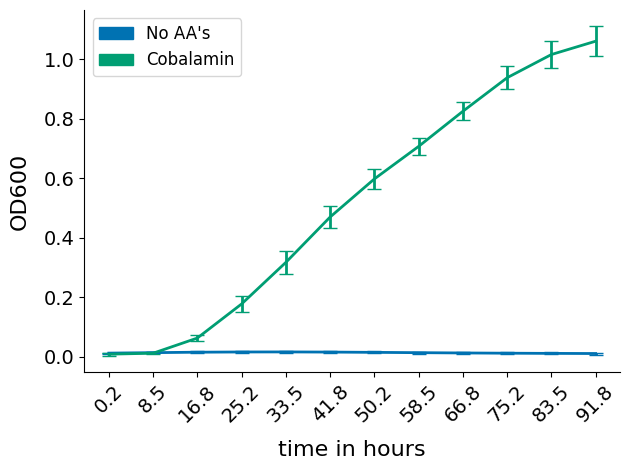

In [13]:
for sample in s_to_d.keys():
    if sample == "noaa" or sample == "cob":
        mean_vals = s_to_d[sample][0]
        std_err = s_to_d[sample][1]
        plt.errorbar(x=range(len(mean_vals[::50])), y=mean_vals[::50], yerr=std_err[::50], capsize=5, color=COLOR_DICT[sample],lw=2)
plt.xticks(range(len(mean_vals[::50])), np.round((np.array(mean_vals[::50].index).astype(float)*10)/60,1), rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("OD600", fontsize=16, labelpad=10)
plt.xlabel("time in hours", fontsize=16, labelpad=10)
patch1 = mpatches.Patch(color=COLOR_DICT["noaa"], label=LABEL_DICT["noaa"]) 
#patch2 = mpatches.Patch(color=COLOR_DICT["met"], label=LABEL_DICT["met"])
patch3 = mpatches.Patch(color=COLOR_DICT["cob"], label=LABEL_DICT["cob"])
#patch4 = mpatches.Patch(color=COLOR_DICT["cobmet"], label=LABEL_DICT["cobmet"])
# Add custom patches to the legend
plt.legend(handles=[patch1, patch3], loc='upper left', fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("../results/figures/cobalamin_growth.svg",dpi=400)

In [14]:
def calculate_generation_times(log_data_dict:dict,start_od=0.3, end_od=0.4)->pd.DataFrame:
    try:
        print("[+] Starting to calculate generation times ...")
        generation_time_dict = {}
        
        for key in log_data_dict.keys():
            
            generation_time_dict[key] = []
            
            old_cols = log_data_dict[key].columns
            new_cols = list(range(len(old_cols)))
            log_data_dict[key].columns = new_cols
            
            for col in log_data_dict[key].columns:
                end_index = -500
                start_index = -500
                switch_0 = False
                switch_1 = False
                for index, value in enumerate(log_data_dict[key][col]):
                    if value >= np.log10(start_od) and switch_0 == False:
                        start_val = value
                        start_index = index
                        switch_0 = True
                    if value >= np.log10(end_od) and switch_1 == False:
                        end_val = value
                        end_index = index
                        switch_1 = True
                if end_index == -500 or start_index == -500:
                    generation_time = 0.0
                else:
                    slope_time = (end_index - start_index) * 10
                    n = ((end_val - start_val)/np.log10(2))
                    generation_time = slope_time / n
                generation_time_dict[key].append(generation_time)
            log_data_dict[key].columns = old_cols
            #print(generation_time_dict)
        
        generation_time_df = pd.DataFrame.from_dict(generation_time_dict, orient='index').transpose()

        print("[+] DONE")
        return generation_time_df
    except Exception as e:
        raise Exception("[-] ERROR calculating generation times with exception: {}".format(e))

In [15]:
log_dict = {}
for key in s_to_d.keys():
    log_dict[key] = np.log10(s_to_d[key][2].T)

In [32]:
gtime_df = np.round(calculate_generation_times(log_dict, 0.1, 0.4) / 60, 2)
gtime_df

[+] Starting to calculate generation times ...
[+] DONE


,noaa,met,cob,cobmet
0,0.0,24.04,9.42,8.01
1,0.0,10.38,9.13,9.31
2,0.0,18.75,8.45,10.04
3,0.0,9.01,8.67,11.34
4,0.0,8.65,9.45,13.98


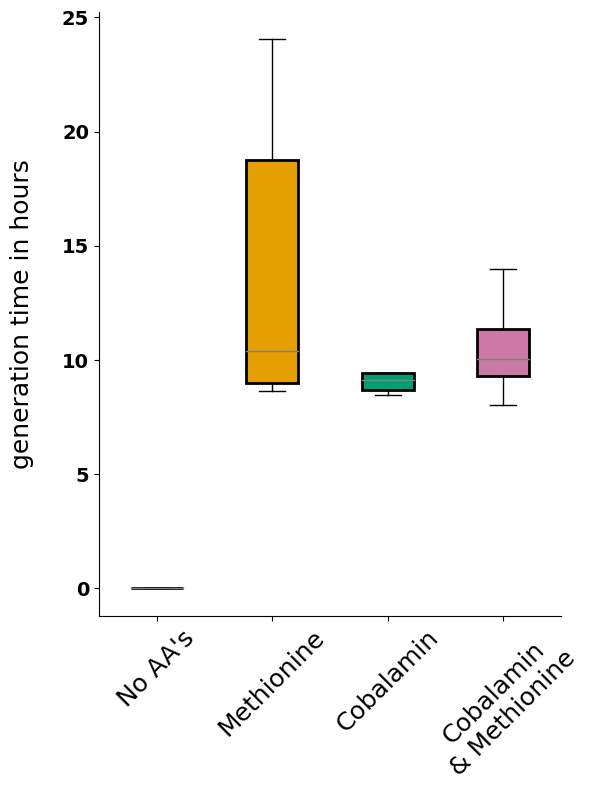

In [33]:
plt.figure(figsize=(6,8))

#fig, ax = plt.subplots()

positions = [0.4,0.8,1.2,1.6] # [0.4,0.8,1.2,1.6]
box = plt.boxplot(gtime_df, positions=positions, meanline=False,
            medianprops=dict(color="grey"), boxprops=dict(color="black", linewidth=2), patch_artist=True)

plt.xticks(positions,["No AA's", "Methionine", "Cobalamin", "Cobalamin\n& Methionine"], rotation=45, fontsize=18)
plt.ylabel("generation time in hours", fontsize=18, labelpad=20)
plt.yticks(fontsize=14, fontweight="bold")
plt.xlim(0.2,max(positions)+0.2)

{"noaa":"#0072B2","met":"#E69F00","cob":"#009E73","cobmet":"#CC79A7"}
colors = ["#0072B2","#E69F00","#009E73","#CC79A7"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
ax = plt.gca()
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("../results/figures/met_cob_generationtime.svg")

In [34]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df_tukey = pd.DataFrame([(key, val) for key, values in dict(gtime_df).items() for val in values], columns=["Group", "Value"])


In [35]:
# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(df_tukey["Value"], df_tukey["Group"])
print(tukey_result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   cob cobmet    1.512 0.9112  -5.0636  8.0876  False
   cob    met    5.142 0.1554  -1.4336 11.7176  False
   cob   noaa   -9.024  0.006 -15.5996 -2.4484   True
cobmet    met     3.63 0.4171  -2.9456 10.2056  False
cobmet   noaa  -10.536 0.0016 -17.1116 -3.9604   True
   met   noaa  -14.166 0.0001 -20.7416 -7.5904   True
-----------------------------------------------------
